# Heart Disease Predictor

## Background

WHO estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.<br>
There are multiple factors taht could contribute to Cardivascular Diseases:<br>
- Unhealthy diet
- Lack of physical activity
- Mental illness<br>
  
We are working with a R&D company that has gathered anonymized data from multiple hospitals. The [data](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

## Goal

Identifying these risk factors early on could help prevent many premature deaths.

## Libraries

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

## Data dictionary

* **Age**: age of the patient [years]
* **Sex**: sex of the patient [M: Male, F: Female]
* **ChestPainType**: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* **RestingBP**: resting blood pressure [mm Hg]
* **Cholesterol**: serum cholesterol [mm/dl]
* **FastingBS**: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* **RestingECG**: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* **MaxHR**: maximum heart rate achieved [Numeric value between 60 and 202]
* **ExerciseAngina**: exercise-induced angina [Y: Yes, N: No]
* **Oldpeak**: oldpeak = ST [Numeric value measured in depression]
* **ST_Slope**: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* **HeartDisease**: output class [1: heart disease, 0: Normal]

## Load Data

In [4]:
heart_df = pd.read_csv('dataset/heart.csv')

## EDA

In [5]:
heart_df.shape

(918, 12)

In [6]:
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [29]:
# Visualizations

numerical_features = heart_df.select_dtypes(include=['number','float', 'int64']).columns
categorical_features = heart_df.select_dtypes(include=['object', 'category']).columns


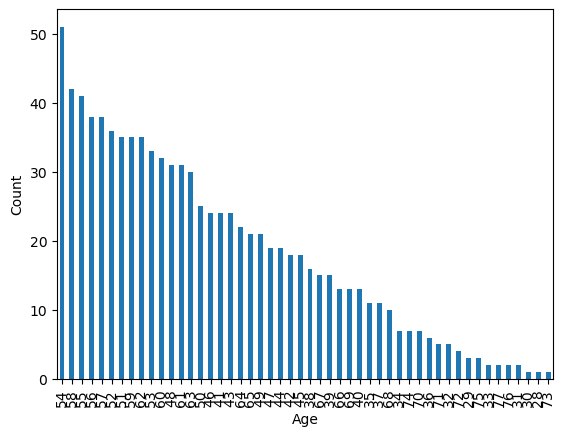

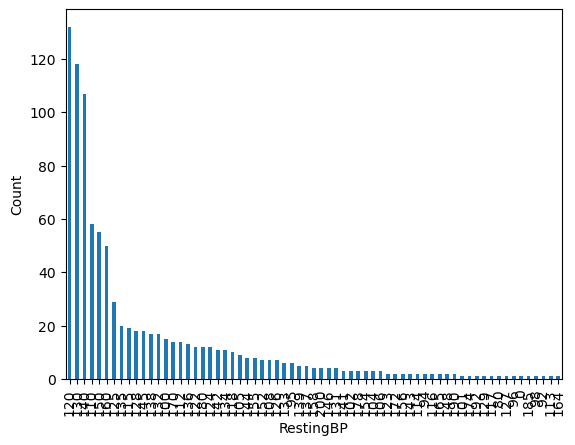

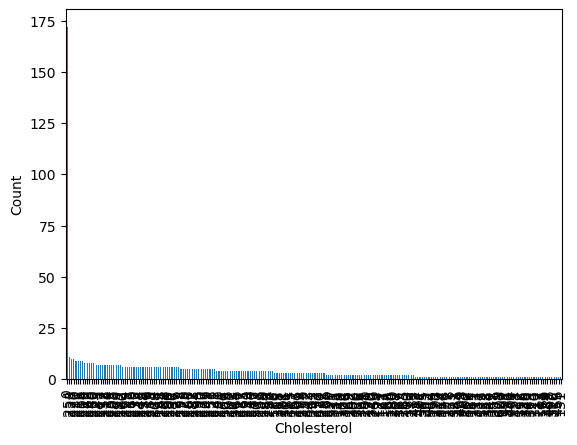

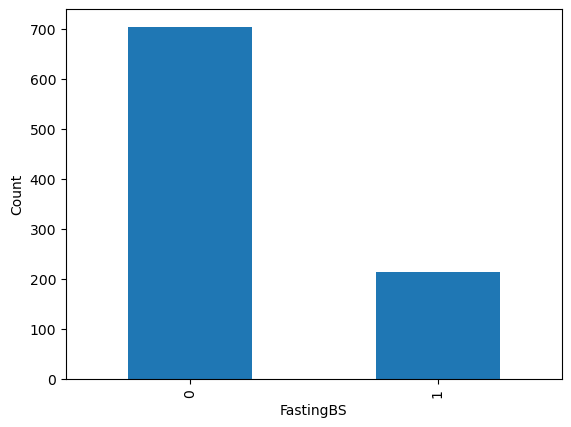

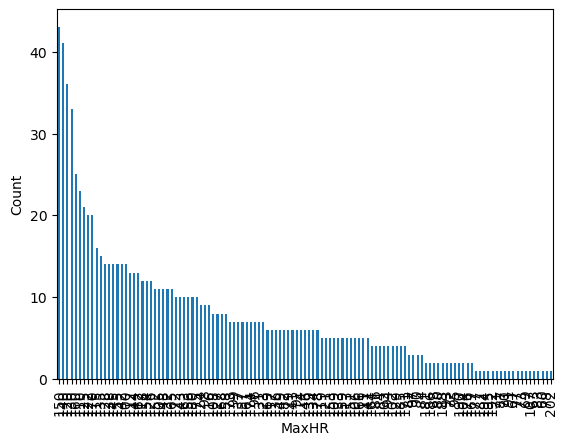

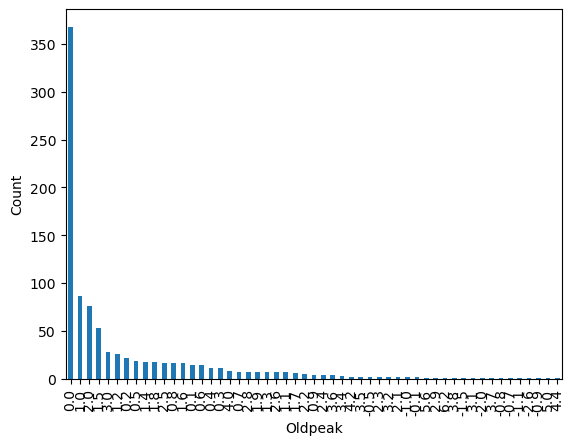

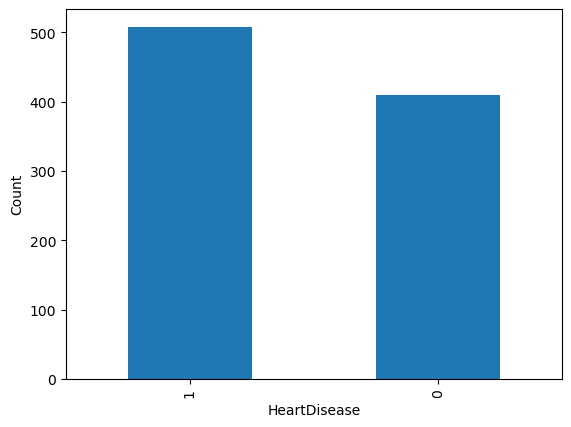

In [34]:

for feature in numerical_features:
    heart_df[feature].value_counts().plot(kind='bar')
    plt.ylabel('Count')
    plt.show()

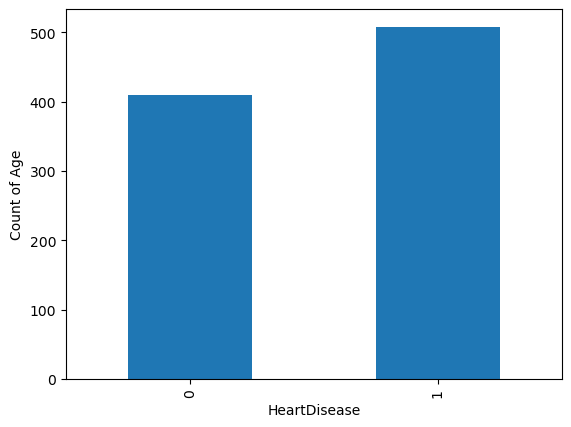

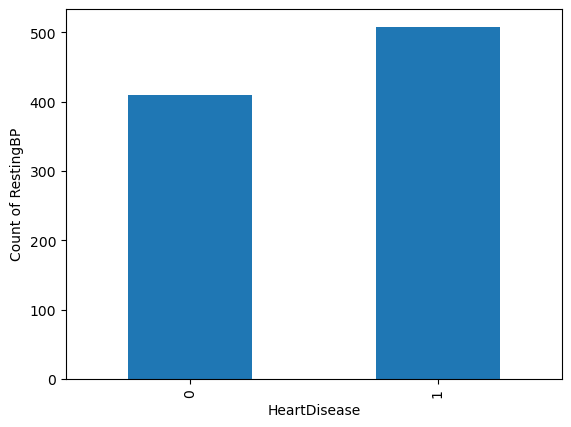

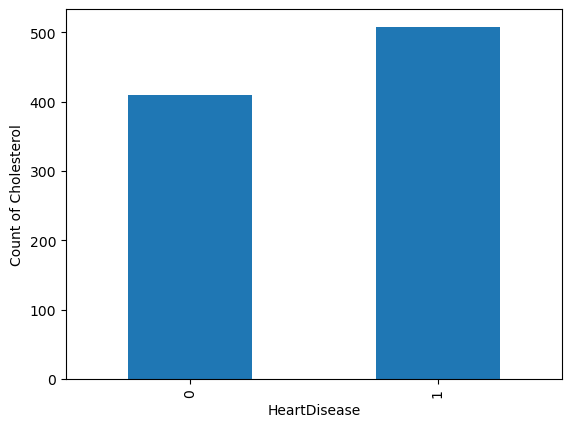

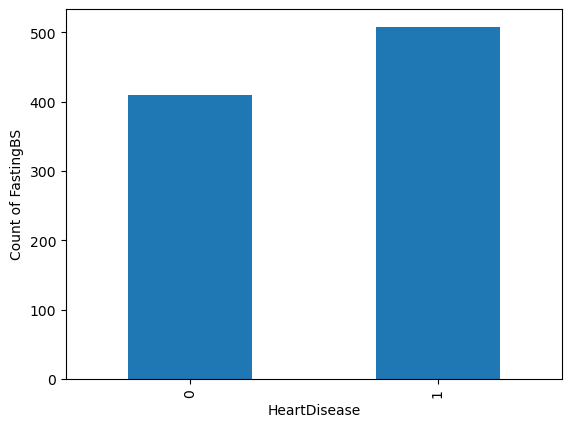

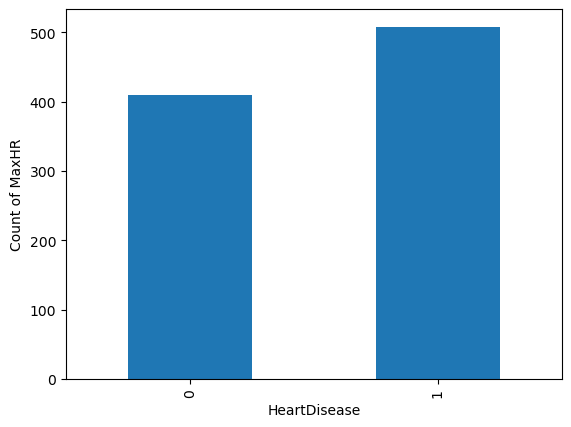

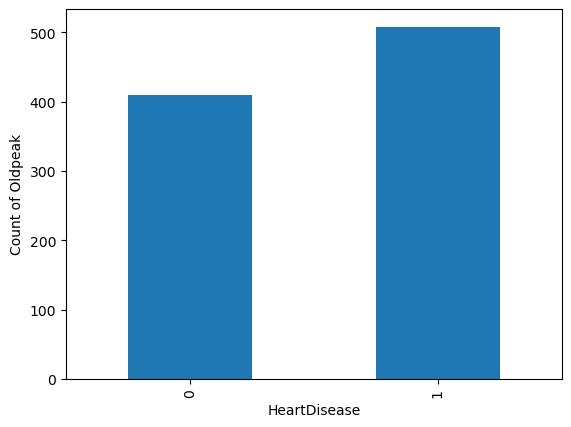

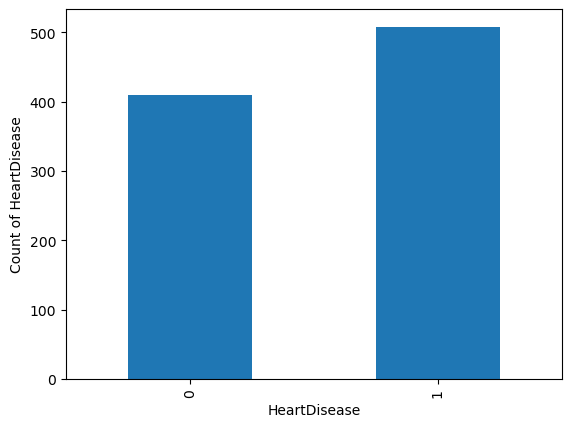

In [37]:
for feature in numerical_features:
    heart_df.groupby('HeartDisease')[feature].count().plot(kind='bar')
    plt.ylabel(f'Count of {feature}')
    plt.show()

### Observations

- The patients have an age range between 28 and 77 years old
  - Our model will be able to confidently predict for that range
- Around 80% of patients are Male
- Around 55% of the observations have hearth disease
- **RestingBP** and **Cholesterol** has many values in 0, we might drop those rows

## Data cleaning

### Data cleaning

The data looks pretty clean

In [41]:
# How many occurencies

print(heart_df[heart_df['RestingBP'] == 0].shape[0])

print(heart_df[heart_df['Cholesterol'] == 0].shape[0])

1
172


We will drop the row for RestingBP and input the mean of Cholesterol

In [43]:
# Drop the RestingBP row
index = heart_df[heart_df['RestingBP'] == 0].index[0]
heart_df.drop(index=index, inplace=True)
print(heart_df[heart_df['RestingBP'] == 0].shape[0])

0


In [47]:
# Input the mean for Cholesterol
cholesterol_mean = round(heart_df['Cholesterol'].mean())
heart_df.loc[heart_df['Cholesterol'] == 0, 'Cholesterol'] = cholesterol_mean
print(heart_df[heart_df['Cholesterol'] == 0].shape[0])

0


### Missing data

In [14]:
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

No missing data

## Feature Engineering

### Feature selection

In [49]:
heart_df = pd.get_dummies(heart_df)

In [55]:
correlations = abs(heart_df.corr()['HeartDisease']).sort_values(ascending=False)[1:]
print(correlations)

ST_Slope_Up          0.621843
ST_Slope_Flat        0.553700
ChestPainType_ASY    0.518339
ExerciseAngina_Y     0.495490
ExerciseAngina_N     0.495490
Oldpeak              0.403638
ChestPainType_ATA    0.401680
MaxHR                0.401410
Sex_F                0.305118
Sex_M                0.305118
Age                  0.282012
FastingBS            0.267994
ChestPainType_NAP    0.215311
ST_Slope_Down        0.122852
RestingBP            0.117990
RestingECG_ST        0.103067
RestingECG_Normal    0.092452
ChestPainType_TA     0.054591
Cholesterol          0.011262
RestingECG_LVH       0.011174
Name: HeartDisease, dtype: float64


There are some strongly linearly correlated variables with HeartDisease, we will pick the top 5<br>
Cholesterol is not strongly correlated!

In [65]:
selected_features = correlations[:5].index
heart_df[selected_features]

,ST_Slope_Up,ST_Slope_Flat,ChestPainType_ASY,ExerciseAngina_Y,ExerciseAngina_N
0,True,False,False,False,True
1,False,True,False,False,True
2,True,False,False,False,True
3,False,True,True,True,False
4,True,False,False,False,True
...,...,...,...,...,...
913,False,True,False,False,True
914,False,True,True,False,True
915,False,True,True,True,False
916,False,True,False,False,True


The selected features are all categorical we will throw in a numerical one: Oldpeak

In [66]:
selected_features_alt = correlations[:6].index
selected_features_alt

Index(['ST_Slope_Up', 'ST_Slope_Flat', 'ChestPainType_ASY', 'ExerciseAngina_Y',
       'ExerciseAngina_N', 'Oldpeak'],
      dtype='object')

## Split data

In [67]:
X = heart_df[selected_features_alt]
y = heart_df['HeartDisease']

In [69]:
# Create validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20, random_state=42)

# Create train and test sets
# X_test should be 20% of X and not of X_train
test_size= 0.20 * X.shape[0] / X_train.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=42)

We have a 80 / 20 / 20 split

## Model fitting and evaluation - on one feature

We will be implementing the model using one feature at a time and compare the results

In [74]:
for feature in selected_features_alt:
    kn = KNeighborsClassifier(n_neighbors=10)
    kn.fit(X_train[[feature]], y_train)
    accuracy = kn.score(X_val[[feature]], y_val)
    print(f"Accuracy with n=10 and {feature} : {accuracy*100:.2f}%")

Accuracy with n=10 and ST_Slope_Up : 78.80%
Accuracy with n=10 and ST_Slope_Flat : 76.09%
Accuracy with n=10 and ChestPainType_ASY : 75.00%
Accuracy with n=10 and ExerciseAngina_Y : 67.39%
Accuracy with n=10 and ExerciseAngina_N : 67.39%
Accuracy with n=10 and Oldpeak : 62.50%


Interestingly they behave the same as its correlation, the higher the better it classifies the data

In [75]:
for feature in selected_features_alt:
    kn = KNeighborsClassifier(n_neighbors=20)
    kn.fit(X_train[[feature]], y_train)
    accuracy = kn.score(X_val[[feature]], y_val)
    print(f"Accuracy with n=10 and {feature} : {accuracy*100:.2f}%")

Accuracy with n=10 and ST_Slope_Up : 78.80%
Accuracy with n=10 and ST_Slope_Flat : 76.09%
Accuracy with n=10 and ChestPainType_ASY : 75.00%
Accuracy with n=10 and ExerciseAngina_Y : 67.39%
Accuracy with n=10 and ExerciseAngina_N : 67.39%
Accuracy with n=10 and Oldpeak : 66.30%


Increasing the K for keep things the same

In [76]:
for feature in selected_features_alt:
    kn = KNeighborsClassifier(n_neighbors=5)
    kn.fit(X_train[[feature]], y_train)
    accuracy = kn.score(X_val[[feature]], y_val)
    print(f"Accuracy with n=10 and {feature} : {accuracy*100:.2f}%")

Accuracy with n=10 and ST_Slope_Up : 78.80%
Accuracy with n=10 and ST_Slope_Flat : 39.13%
Accuracy with n=10 and ChestPainType_ASY : 39.13%
Accuracy with n=10 and ExerciseAngina_Y : 32.61%
Accuracy with n=10 and ExerciseAngina_N : 67.39%
Accuracy with n=10 and Oldpeak : 59.78%


With k=5 the accuracy of many models decreased abruptly

Let's use all of our features to create the classifier, but first we need to scale them.

## Feature Engineering II

### Standardize data

In [78]:
mm = MinMaxScaler()

In [79]:
X_train_scaled = mm.fit_transform(X_train[selected_features_alt])
X_val_scaled = mm.transform(X_val[selected_features_alt])


## Model fitting and evaluation II - All the features

In [81]:
kn = KNeighborsClassifier(n_neighbors=10)
kn.fit(X_train_scaled, y_train)
accuracy = kn.score(X_val_scaled, y_val)
print(f"Accuracy with n=10 and all features selected : {accuracy*100:.2f}%")

Accuracy with n=10 and all features selected : 81.52%


We got a bump in performance using more features in almost 3%

## Hyperparameter optimization

### Setup for Grid Search

Grid Search creates its own validation (Cross Validation) set so we need some adjustments to our data

In [82]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [83]:
# Scale train set
X_train_scaled = mm.fit_transform(X_train[selected_features_alt])

### Grid Search

In [86]:
grid_search_dict = {
    'n_neighbors':[5, 10, 50, 100],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'brute'],
    'leaf_size': [30, 40, 50]
}

kn = KNeighborsClassifier()
gs = GridSearchCV(estimator=kn, param_grid=grid_search_dict, scoring='accuracy') 

In [87]:
# fiting model
gs.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'brute'],
                         'leaf_size': [30, 40, 50],
                         'n_neighbors': [5, 10, 50, 100],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [88]:
print(gs.best_score_)
print(gs.best_params_)


0.8552790979405461
{'algorithm': 'brute', 'leaf_size': 30, 'n_neighbors': 10, 'weights': 'uniform'}


With Grid Search we were able to push the model up 4% more

## Testing model

In [89]:
# Scale test set, only transforming
X_test_scaled = mm.transform(X_test[selected_features_alt])

In [90]:
# Evaluate the scaled test set using the best estimator,
accuracy = gs.best_estimator_.score(X_test_scaled, y_test)
print(accuracy)

0.8206521739130435


On our test set we got an accuracy of 82%, this decrease is expected due to testing over unseen data.

While it is a good accuracy for medical purposes it shoudl be used with care. <br>
Some approaches to increase performance:
- Increase the input data, we are working with only around 1k observations
- Explore more hyperparameter optimization
- Try to increase the features utilized, there are more features that have a high correlation with the target feature

## Exporting model

We can use libraries to export our trained model so that we can use it in other places